# 线性回归的从零开始实现

In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

为了简单起见，将根据带有噪声的线性模型构造一个人造数据集。
在下面的代码中，我们生成一个包含 1000 个样本的数据集 $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$，每个样本包含从标准正态分布中采样的 2 个特征。
我们使用线性模型参数 $\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$ 和噪声项 $\epsilon$ 生成数据集及其标签：$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$。
$\epsilon$可以视为模型预测和标签时的潜在观测误差，我们认为标准假设成立，即 $\epsilon$ 服从均值为 0 的正态分布，为了简化问题，将标准差设为 0.01。

In [13]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [14]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.5905, -0.4000]) 
label: tensor([6.7319])


`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）。

通过生成第二个特征 `features[:, 1]` 和 `labels` 的散点图，可以直观观察到两者之间的线性关系。

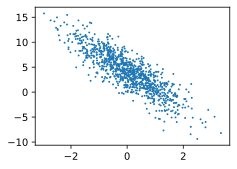

In [15]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

## 读取数据集

训练模型需要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新模型。
因此需要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。
定义一个 `data_iter` 函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量，每个小批量包含一组特征和标签。

In [16]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

作为展示，读取第一个小批量数据样本并打印，每个批量的特征维度显示批量大小和输入特征数。

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1886,  0.4455],
        [-1.5722, -0.1032],
        [ 0.8057,  1.2083],
        [ 0.9748,  0.9487],
        [-0.8781,  0.3307],
        [-0.3892, -0.3822],
        [ 0.8517, -0.5844],
        [ 0.1482, -0.3343],
        [ 0.1450,  0.8571],
        [ 1.3927,  0.1007]]) 
 tensor([[0.3319],
        [1.4118],
        [1.7029],
        [2.9321],
        [1.3157],
        [4.7211],
        [7.8878],
        [5.6483],
        [1.5695],
        [6.6461]])


## 参数初始化

开始训练（用小批量随机梯度下降优化模型参数）之前，需要先有一些参数。
在下面的代码中，通过从均值为 0、标准差为 0.01 的正态分布中采样随机数来初始化权重，并将偏置初始化为 0。

In [18]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，训练任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度，有了这个梯度，就可以向减小损失的方向更新每个参数。

## 定义模型

要计算线性模型的输出，只需计算输入特征 $\mathbf{X}$ 和模型权重 $\mathbf{w}$ 的矩阵-向量乘法后加上偏置 $b$。

In [19]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 定义损失函数

这里使用平方损失函数，在实现中，需要将真实值 `y` 的形状转换为和预测值 `y_hat` 的形状相同。

In [20]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 定义优化器：小批量随机梯度

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。
每一组 batch_size 更新一次参数，也就是朝着减少损失的方向更新参数。
下面的函数实现小批量随机梯度下降更新，该函数接受模型参数集合、学习速率和批量大小作为输入，每一步更新的大小由学习速率 `lr` 决定。
因为我们计算的损失是一个批量样本的总和，所以用批量大小 `batch_size` 来规范化步长，这样步长大小就不会取决于批量大小的选择。

In [21]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

现在，已经准备好了模型训练所有需要的要素，可以实现主要的训练过程部分了。
理解这段代码至关重要，因为从事深度学习后，相同的训练过程几乎一遍又一遍地出现。
在每次迭代中，读取一小批量训练样本，并通过事先的模型来获得一组预测。
计算完损失后，开始反向传播，存储每个参数的梯度。
最后，调用优化算法 `sgd` 来更新模型参数。

概括一下，整个训练将执行以下循环：

* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

在每个 Epoch 中，使用 `data_iter` 函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。
这里的迭代周期个数 `num_epochs` 和学习率 `lr` 都是超参数，分别设为 3（也就是整个数据集会被使用 3 次） 和 0.03。

In [22]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [23]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043124
epoch 2, loss 0.000168
epoch 3, loss 0.000050


因为使用的是合成的数据集，所以知道真正的参数是什么。
因此，可以通过*比较真实参数和通过训练学到的参数来评估训练的成功程度。
事实上，真实参数和通过训练学到的参数确实非常接近。

In [24]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0006, -0.0001], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0001], grad_fn=<RsubBackward1>)
